In [1]:
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

# Read from CSV and drop comments and empty rows above from actual turbine data.
df = spark.read.format("csv").option("header", "false").option("inferSchema", "true").load("/FileStore/tables/turbine_power_data.csv")
df = df.withColumn('index', monotonically_increasing_id()).filter("index > 6").drop("index")
# Remove rows with null, empty cells and corrupt data (non-integers like find_me)
#Total records before removing nulls 26,633
#Removing whole row, if null value or empty cells present in any cloumn except _c0 column.
df = df.dropna(how='any')
#Remove rows with 'null' value in '_c0' column
df = df.filter(~(df["_c0"]=='null')) # 30 rows with null value in '_c0' column
#df.where((df["_c3"] == "") | (df["_c3"].isNull())| (isnan(df["_c3"])).count()
#Total records after removing nulls 26,547
#Remove corrupt data i.e. non-numeric records like 'find_me' from any column.
expr = "\\d+"
df = df.filter(df["_c1"].rlike(expr) & df["_c2"].rlike(expr) & df["_c3"].rlike(expr) )
#Total records after removing non-numeric cell values from _c1 26,486
#df.select("*").where(df._c1 == 'find_me')

#convert time column to timestamp and power values to double.
df =  df.withColumn("time", unix_timestamp('_c0', "M/d/yyyy HH:mm").cast(TimestampType())) \
        .withColumn("turbine1", df._c1.cast(DoubleType())).withColumn("turbine2", df._c2.cast(DoubleType())) \
        .withColumn("turbine3", df._c3.cast(DoubleType())).drop("_c0","_c1","_c2","_c3") 

df.show()

+-------------------+--------+--------+--------+
 time|turbine1|turbine2|turbine3|
+-------------------+--------+--------+--------+
2020-01-01 00:01:00| 7390.0| 1592.0| 5751.0|
2020-01-01 00:02:00| 10000.0| 5942.0| 649.0|
2020-01-01 00:03:00| 1116.0| 9414.0| 4224.0|
2020-01-01 00:04:00| 3301.0| 5291.0| 5558.0|
2020-01-01 00:05:00| 9086.0| 3830.0| 8564.0|
2020-01-01 00:06:00| 1352.0| 8963.0| 5050.0|
2020-01-01 00:07:00| 7748.0| 8796.0| 605.0|
2020-01-01 00:08:00| 5209.0| 5785.0| 3045.0|
2020-01-01 00:09:00| 9019.0| 6855.0| 1734.0|
2020-01-01 00:10:00| 7140.0| 6040.0| 3220.0|
2020-01-01 00:11:00| 7664.0| 6378.0| 7213.0|
2020-01-01 00:12:00| 7902.0| 5029.0| 1391.0|
2020-01-01 00:13:00| 7528.0| 1948.0| 9972.0|
2020-01-01 00:14:00| 6707.0| 6803.0| 6085.0|
2020-01-01 00:15:00| 746.0| 657.0| 1845.0|
2020-01-01 00:16:00| 1193.0| 7303.0| 2246.0|
2020-01-01 00:17:00| 3053.0| 8264.0| 6988.0|
2020-01-01 00:18:00| 2606.0| 9756.0| 9307.0|
2020-01-01 00:19:00| 2175.0| 8397.0| 5280.0|
2020-01-01 00:20:00| 9646.0| 823.0| 5705.0|
+-------------------+--------+--------+--------+
only showing top 20 rows

In [2]:
#Convert columns to rows
def to_explode(df, by):
    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes if c not in by))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"
    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("turbine"), col(c).alias("power")) for c in cols
    ])).alias("kvs")
    return df.select(by + [kvs]).select(by + ["kvs.turbine", "kvs.power"])
  
df = to_explode(df, ['time'])     
df.show(60)


+-------------------+--------+-------+
 time| turbine| power|
+-------------------+--------+-------+
2020-01-01 00:01:00|turbine1| 7390.0|
2020-01-01 00:01:00|turbine2| 1592.0|
2020-01-01 00:01:00|turbine3| 5751.0|
2020-01-01 00:02:00|turbine1|10000.0|
2020-01-01 00:02:00|turbine2| 5942.0|
2020-01-01 00:02:00|turbine3| 649.0|
2020-01-01 00:03:00|turbine1| 1116.0|
2020-01-01 00:03:00|turbine2| 9414.0|
2020-01-01 00:03:00|turbine3| 4224.0|
2020-01-01 00:04:00|turbine1| 3301.0|
2020-01-01 00:04:00|turbine2| 5291.0|
2020-01-01 00:04:00|turbine3| 5558.0|
2020-01-01 00:05:00|turbine1| 9086.0|
2020-01-01 00:05:00|turbine2| 3830.0|
2020-01-01 00:05:00|turbine3| 8564.0|
2020-01-01 00:06:00|turbine1| 1352.0|
2020-01-01 00:06:00|turbine2| 8963.0|
2020-01-01 00:06:00|turbine3| 5050.0|
2020-01-01 00:07:00|turbine1| 7748.0|
2020-01-01 00:07:00|turbine2| 8796.0|
2020-01-01 00:07:00|turbine3| 605.0|
2020-01-01 00:08:00|turbine1| 5209.0|
2020-01-01 00:08:00|turbine2| 5785.0|
2020-01-01 00:08:00|turbine3| 3045.0|
2020-01-01 00:09:00|turbine1| 9019.0|
2020-01-01 00:09:00|turbine2| 6855.0|
2020-01-01 00:09:00|turbine3| 1734.0|
2020-01-01 00:10:00|turbine1| 7140.0|
2020-01-01 00:10:00|turbine2| 6040.0|
2020-01-01 00:10:00|turbine3| 3220.0|
2020-01-01 00:11:00|turbine1| 7664.0|
2020-01-01 00:11:00|turbine2| 6378.0|
2020-01-01 00:11:00|turbine3| 7213.0|
2020-01-01 00:12:00|turbine1| 7902.0|
2020-01-01 00:12:00|turbine2| 5029.0|
2020-01-01 00:12:00|turbine3| 1391.0|
2020-01-01 00:13:00|turbine1| 7528.0|
2020-01-01 00:13:00|turbine2| 1948.0|
2020-01-01 00:13:00|turbine3| 9972.0|
2020-01-01 00:14:00|turbine1| 6707.0|
2020-01-01 00:14:00|turbine2| 6803.0|
2020-01-01 00:14:00|turbine3| 6085.0|
2020-01-01 00:15:00|turbine1| 746.0|
2020-01-01 00:15:00|turbine2| 657.0|
2020-01-01 00:15:00|turbine3| 1845.0|
2020-01-01 00:16:00|turbine1| 1193.0|
2020-01-01 00:16:00|turbine2| 7303.0|
2020-01-01 00:16:00|turbine3| 2246.0|
2020-01-01 00:17:00|turbine1| 3053.0|
2020-01-01 00:17:00|turbine2| 8264.0|
2020-01-01 00:17:00|turbine3| 6988.0|
2020-01-01 00:18:00|turbine1| 2606.0|
2020-01-01 00:18:00|turbine2| 9756.0|
2020-01-01 00:18:00|turbine3| 9307.0|
2020-01-01 00:19:00|turbine1| 2175.0|
2020-01-01 00:19:00|turbine2| 8397.0|
2020-01-01 00:19:00|turbine3| 5280.0|
2020-01-01 00:20:00|turbine1| 9646.0|
2020-01-01 00:20:00|turbine2| 823.0|
2020-01-01 00:20:00|turbine3| 5705.0|
+-------------------+--------+-------+
only showing top 60 rows

In [3]:
# Resample the data at 10 min granularity for each turbine.
def resample(column, agg_interval=600, time_format='yyyy-MM-dd-HH:mm:ss'):   
    # Convert the timestamp to unix timestamp format.
    # Unix timestamp = number of seconds since 00:00:00 UTC, 1 January 1970.
    col_ut =  unix_timestamp(column, format=time_format)
    # Divide the time into dicrete intervals, by rounding. 
    col_ut_agg =  floor(col_ut / agg_interval) * agg_interval
    # Convert to and return a human readable timestamp
    return from_unixtime(col_ut_agg).cast(TimestampType())
  
df = df.withColumn('time_10Min_resampled', resample(df.time, agg_interval=600)).drop('time') #79548 rows
df.show(60)

+--------+-------+--------------------+
 turbine| power|time_10Min_resampled|
+--------+-------+--------------------+
turbine1| 7390.0| 2020-01-01 00:00:00|
turbine2| 1592.0| 2020-01-01 00:00:00|
turbine3| 5751.0| 2020-01-01 00:00:00|
turbine1|10000.0| 2020-01-01 00:00:00|
turbine2| 5942.0| 2020-01-01 00:00:00|
turbine3| 649.0| 2020-01-01 00:00:00|
turbine1| 1116.0| 2020-01-01 00:00:00|
turbine2| 9414.0| 2020-01-01 00:00:00|
turbine3| 4224.0| 2020-01-01 00:00:00|
turbine1| 3301.0| 2020-01-01 00:00:00|
turbine2| 5291.0| 2020-01-01 00:00:00|
turbine3| 5558.0| 2020-01-01 00:00:00|
turbine1| 9086.0| 2020-01-01 00:00:00|
turbine2| 3830.0| 2020-01-01 00:00:00|
turbine3| 8564.0| 2020-01-01 00:00:00|
turbine1| 1352.0| 2020-01-01 00:00:00|
turbine2| 8963.0| 2020-01-01 00:00:00|
turbine3| 5050.0| 2020-01-01 00:00:00|
turbine1| 7748.0| 2020-01-01 00:00:00|
turbine2| 8796.0| 2020-01-01 00:00:00|
turbine3| 605.0| 2020-01-01 00:00:00|
turbine1| 5209.0| 2020-01-01 00:00:00|
turbine2| 5785.0| 2020-01-01 00:00:00|
turbine3| 3045.0| 2020-01-01 00:00:00|
turbine1| 9019.0| 2020-01-01 00:00:00|
turbine2| 6855.0| 2020-01-01 00:00:00|
turbine3| 1734.0| 2020-01-01 00:00:00|
turbine1| 7140.0| 2020-01-01 00:10:00|
turbine2| 6040.0| 2020-01-01 00:10:00|
turbine3| 3220.0| 2020-01-01 00:10:00|
turbine1| 7664.0| 2020-01-01 00:10:00|
turbine2| 6378.0| 2020-01-01 00:10:00|
turbine3| 7213.0| 2020-01-01 00:10:00|
turbine1| 7902.0| 2020-01-01 00:10:00|
turbine2| 5029.0| 2020-01-01 00:10:00|
turbine3| 1391.0| 2020-01-01 00:10:00|
turbine1| 7528.0| 2020-01-01 00:10:00|
turbine2| 1948.0| 2020-01-01 00:10:00|
turbine3| 9972.0| 2020-01-01 00:10:00|
turbine1| 6707.0| 2020-01-01 00:10:00|
turbine2| 6803.0| 2020-01-01 00:10:00|
turbine3| 6085.0| 2020-01-01 00:10:00|
turbine1| 746.0| 2020-01-01 00:10:00|
turbine2| 657.0| 2020-01-01 00:10:00|
turbine3| 1845.0| 2020-01-01 00:10:00|
turbine1| 1193.0| 2020-01-01 00:10:00|
turbine2| 7303.0| 2020-01-01 00:10:00|
turbine3| 2246.0| 2020-01-01 00:10:00|
turbine1| 3053.0| 2020-01-01 00:10:00|
turbine2| 8264.0| 2020-01-01 00:10:00|
turbine3| 6988.0| 2020-01-01 00:10:00|
turbine1| 2606.0| 2020-01-01 00:10:00|
turbine2| 9756.0| 2020-01-01 00:10:00|
turbine3| 9307.0| 2020-01-01 00:10:00|
turbine1| 2175.0| 2020-01-01 00:10:00|
turbine2| 8397.0| 2020-01-01 00:10:00|
turbine3| 5280.0| 2020-01-01 00:10:00|
turbine1| 9646.0| 2020-01-01 00:20:00|
turbine2| 823.0| 2020-01-01 00:20:00|
turbine3| 5705.0| 2020-01-01 00:20:00|
+--------+-------+--------------------+
only showing top 60 rows

In [4]:
#Sum the power value of all 3 turbines and get the Farm level power at 10 min granularity.
#Using GroupBy is not good for performance. Use Windows functions.
df_grpby_farmPowerSum = df.groupBy('time_10Min_resampled').agg(sum('power').alias('farmpowersum'))
print("Total Rows : " + str(df_grpby_farmPowerSum.count()))
df_grpby_farmPowerSum.show(5) 


Total Rows : 252
+--------------------+------------+
time_10Min_resampled|farmpowersum|
+--------------------+------------+
 2020-01-01 22:00:00| 1852217.0|
 2020-01-04 04:00:00| 17393.0|
 2020-01-01 06:30:00| 1851198.0|
 2020-01-04 02:40:00| 102295.0|
 2020-01-01 15:10:00| 1806106.0|
+--------------------+------------+
only showing top 5 rows

In [5]:
#Sum the power value of all 3 turbines and get the Farm level power at 10 min granularity.
from pyspark.sql.window import Window
window10MSpecPartition = Window.partitionBy(df['time_10Min_resampled']).orderBy(df['time_10Min_resampled'].asc()) 
df_farmPowerSum = df.withColumn("farmpowersum",sum(df.power).over(window10MSpecPartition))
#GroupBy gives only one row for aggregated sum. But windows function shows all rows, which are duplicates and not required, so dropping them.
df_farmPowerSum = df_farmPowerSum.drop("turbine","power").dropDuplicates()
print("Total Rows : " + str(df_farmPowerSum.count()))
df_farmPowerSum.show()

Total Rows : 252
+--------------------+------------+
time_10Min_resampled|farmpowersum|
+--------------------+------------+
 2020-01-01 22:00:00| 1852217.0|
 2020-01-04 04:00:00| 17393.0|
 2020-01-01 06:30:00| 1851198.0|
 2020-01-04 02:40:00| 102295.0|
 2020-01-01 15:10:00| 1806106.0|
 2020-01-01 11:20:00| 1933380.0|
 2020-01-02 09:20:00| 1697185.0|
 2020-01-02 09:50:00| 1761569.0|
 2020-01-01 07:30:00| 1719377.0|
 2020-01-01 18:10:00| 1827100.0|
 2020-01-01 00:50:00| 1724243.0|
 2020-01-02 01:20:00| 1785710.0|
 2020-01-02 03:50:00| 1773203.0|
 2020-01-04 02:20:00| 117663.0|
 2020-01-01 14:00:00| 1777747.0|
 2020-01-01 23:50:00| 1835545.0|
 2020-01-01 20:20:00| 1753089.0|
 2020-01-01 16:50:00| 1655757.0|
 2020-01-04 00:00:00| 154400.0|
 2020-01-01 17:10:00| 1626124.0|
+--------------------+------------+
only showing top 20 rows

In [6]:
import pandas as pd
#delete single file
dbutils.fs.rm("/FileStore/tables/farmPowerSum.csv")
#Delete folder
# %fs rm -r /FileStore/tables/farmPowerSum.csv/

#https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

Out[126]: True

In [7]:
import numpy as np 
import pandas as pd  
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline
#Convert Spark DF to panads DF
data = pd.DataFrame(df_farmPowerSum.toPandas())
# Set time_10Min_resmapled column as index
data.set_index('time_10Min_resampled', inplace=True)


In [8]:
#Fetuare Engineering: creating new features to solve the forecasting as a regression problem.
# Creating lagged features of the target variable "farmpowersum", from 6 steps back up to 10
for i in range(6, 11):
    data["lag_{}".format(i)] = data.farmpowersum.shift(i)

# Creating/engineering date based features
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail(7)    

,farmpowersum,lag_6,lag_7,lag_8,lag_9,lag_10,weekday,is_weekend
time_10Min_resampled,,,,,,,,
2020-01-02 04:50:00,1832596.0,1687884.0,1625522.0,1661407.0,1757800.0,1766971.0,3,0
2020-01-04 00:20:00,162393.0,1827150.0,1687884.0,1625522.0,1661407.0,1757800.0,5,1
2020-01-02 05:00:00,1748084.0,1747660.0,1827150.0,1687884.0,1625522.0,1661407.0,3,0
2020-01-01 02:40:00,1561772.0,1781268.0,1747660.0,1827150.0,1687884.0,1625522.0,2,0
2020-01-01 12:40:00,1778866.0,1733810.0,1781268.0,1747660.0,1827150.0,1687884.0,2,0
2020-01-02 00:00:00,1829616.0,1878923.0,1733810.0,1781268.0,1747660.0,1827150.0,3,0
2020-01-02 08:30:00,1626188.0,1832596.0,1878923.0,1733810.0,1781268.0,1747660.0,3,0


In [9]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
  
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies    
    """    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

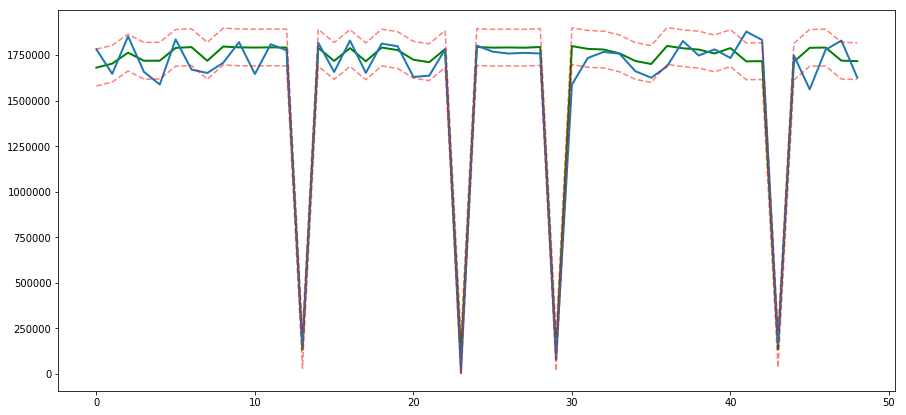

In [10]:
'''Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and regularization.'''

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

y = data.dropna().farmpowersum	
X = data.dropna().drop(['farmpowersum'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)